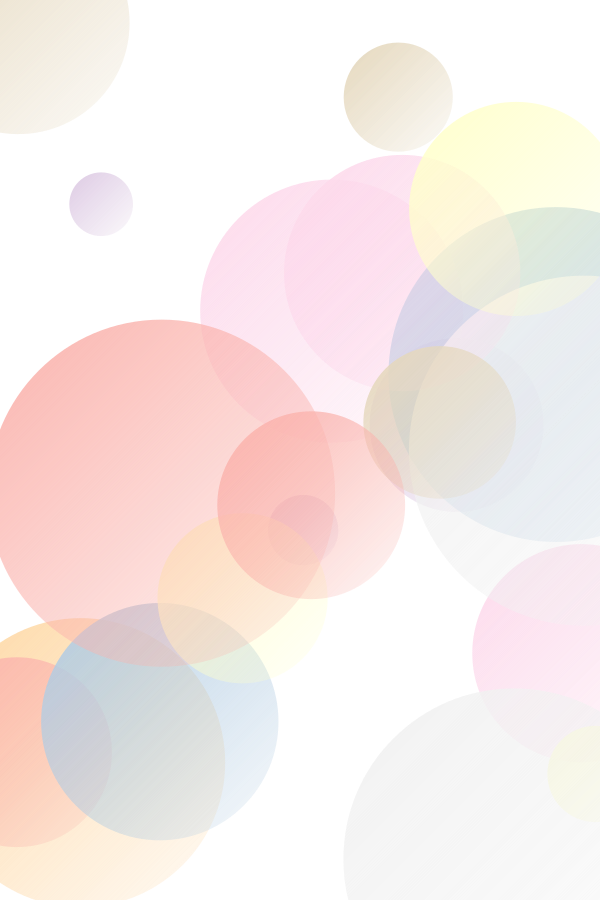

In [61]:
from IPython.display import display
import math
import svgwrite
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime
import os

###################################

def w(p):
    return p/100 * WIDTH

def h(p):
    return p/100 * HEIGHT

###################################

WIDTH = 600
HEIGHT = 900
NUMBER_OF_BUBBLES = 20
COLOR_SCHEME = 'Pastel1'
IS_ANIMATED = True
IS_DISTORTED = True
HAS_NOISE = False
SAVE_OUTPUT = False
DISPLAY_OUTPUT = True
SEED = 1

###################################

random.seed(SEED)
colors = [mcolors.rgb2hex(color) for color in plt.get_cmap(COLOR_SCHEME).colors]
dwg = svgwrite.Drawing('circle_example.svg', profile='full', size=(WIDTH, HEIGHT))

# Define some filters
distort_filter = dwg.defs.add(dwg.filter(id='distortFilter'))
distort_filter.feTurbulence(type="fractalNoise", baseFrequency=0.05, numOctaves=10, result="turbulence")
distort_filter.feDisplacementMap(in2="turbulence", in_="SourceGraphic", scale=100)

noise_filter = dwg.defs.add(dwg.filter(id='noiseFilter'))
noise_filter.feTurbulence(type="fractalNoise", baseFrequency=0.8, numOctaves=10, result="turbulence")
noise_filter.feComposite(operator="in", in_="turbulence", in2="SourceAlpha", result="composite")
noise_filter.feColorMatrix(in_="composite", type="luminanceToAlpha")
noise_filter.feBlend(in_="SourceGraphic", in2="composite", mode="multiply")

for i in range(NUMBER_OF_BUBBLES):
    # define the center & size of the circle
    x = 100 * random.random()
    y = 100 * random.random()
    
    min_r = 5
    max_r = 30
    
    r = (max_r - min_r) * random.random() + min_r
    
    base_color = random.choice(colors)
    # define the gradient for the circle
    # Define a linear gradient
    gradient_id = "gradient-" + str(i)
    linear_gradient = dwg.linearGradient((0, 0), (1, 1), id=gradient_id)
    linear_gradient.add_stop_color(0, base_color, 1)
    linear_gradient.add_stop_color(1, base_color, 0.1)

    # Add the gradient definition to the SVG
    dwg.defs.add(linear_gradient)
    
    # define the circle itself
    circle = dwg.circle(center=(w(x), h(y)), r=w(r), fill=f'url(#{gradient_id})')
    if IS_DISTORTED: circle.attribs['filter'] = "url(#distortFilter)"
    
    min_speed = 4
    max_speed = 20
    
    speed = (max_speed - min_speed) * random.random() + min_speed
    
    if IS_ANIMATED:
        # define the animation
        animate = dwg.animate(
            attributeName="cy",
            from_=h(y),      # Starting y position
            to=h(y)-h(speed),         # Ending y position (moves up)
            dur="20s",         # Duration of the animation
            repeatCount="indefinite",  # Loop the animation indefinitely
            values=[h(y), h(y)-h(speed), h(y)],  # cy values at keyframes as a list of strings
            keyTimes="0;0.5;1",  # Keyframe times as a space-separated string
            calcMode="spline",  # Use spline mode for smooth easing
            keySplines="0.42 0 0.58 1;0.42 0 0.58 1"  # Control points for easing
        )
        
        circle.add(animate)
    dwg.add(circle)
    
if HAS_NOISE:
    rect = dwg.rect(insert=(0, 0), size=(w(100), h(100)), fill=random.choice(colors), fill_opacity=0.2, filter="url(#noiseFilter)")
    dwg.add(rect)

if SAVE_OUTPUT:
    # Define the output directory
    output_dir = 'output'  # Replace with your desired directory

    # Ensure the directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Create the full file path
    filename = f'bubbles_no-{NUMBER_OF_BUBBLES}_colors-{COLOR_SCHEME}_{'animated' if IS_ANIMATED else ''}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.svg'
    full_path = os.path.join(output_dir, filename)

    # Save the drawing to the specified directory
    dwg.saveas(full_path)

if DISPLAY_OUTPUT:
    display(dwg)